In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_sphere
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.reconst.shm import CsaOdfModel, QballModel

from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage

import os
import sys
sys.path.insert(0,'..')
import odfs
from tqdm import tqdm

In [3]:
# helper functions for visualization
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, B=None, rot=True, norm=True, scale=True, title='Modeling', theta_step=30):
    '''
    Render a spherical function to file. Returns path to image.
    '''
    
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                               sphere=sphere, colormap='jet',
                               norm=norm)#, radial_scale=scale)
    
#     sf_actor = actor.odf_slicer(sf,
#                            sphere=sphere, colormap='jet',
#                            norm=norm, B_matrix=B)#, radial_scale=scale)
        
    if rot:
        sf_actor.RotateX(-90)
#         sf_actor.RotateY(180)
        sf_actor.RotateZ(180)
    scene.add(sf_actor)
    
    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
#         sf_actor.RotateX(theta_step)
#         sf_actor.RotateY(theta_step)
        sf_actor.RotateZ(theta_step)
        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
        
    frame_duration = 15000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                  duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename
    
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile

def display_slice(odfs, sphere, norm=True, B=None):
    '''
    odfs : odf field as spherical harmonics
    B : spherical harmonic to spherical function matrix
    sphere : dipy Sphere
    norm : normalizes so the maximum ODF amplitude per voxel is 1
    '''
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(odfs,
                               sphere=sphere, colormap='jet',
                               norm=norm, B_matrix=B)#, radial_scale=scale)
    scene.add(sf_actor)
    
    window.show(scene, size=WINDOW_SIZE)
    
    return scene

In [4]:
dwi_raw = '/home/brysongray/data/human_amyg/MRI/dwi_rawdata.nii'

dwi_raw_nii = nib.load(dwi_raw)
dwi = dwi_raw_nii.get_fdata()
print(f'dwi shape: {dwi.shape}')

dwi shape: (110, 110, 120, 95)


In [5]:
b3k_ids = np.arange(6,94,3)
b3k_ids = np.insert(b3k_ids,0, 0)
print(b3k_ids)
dwi_b3k = dwi[...,b3k_ids]

[ 0  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69 72
 75 78 81 84 87 90 93]


In [ ]:
dwi_b3k.shape

In [6]:
gtab_file = '/home/brysongray/data/human_amyg/MRI/gradient_table.txt'
with open(gtab_file, 'r') as f:
    gtab = []
    for line in f:
        gtab_ = [float(x) for x in line.split(sep=',')]
        gtab.append(gtab_)
# gtab = [gtab[i] for i in b3k_ids]
gtab = np.array(gtab)[b3k_ids]
# for g in gtab:
#     print(g)
bvecs = gtab[:,:3]
bvals = gtab[:,3]
# make bvecs unit length
bvecs_norm = np.sqrt(np.sum(bvecs**2, axis=1))
bvecs_norm[0] = 1.
bvecs = bvecs / bvecs_norm[...,None]
print(bvecs)
print(bvals)
gtab = gradient_table(bvals, bvecs)

# bvals_test = bvals
# bvecs_test = np.insert(bvecs, bvecs.shape[0], np.array([0,0,0]), axis = 0)
# bvals_test = np.insert(bvals[1:], (0, bvals.shape[0]-1), 0)
# print(bvecs_test)
# print(bvals_test)
# gtab_test = gradient_table(bvals_test, bvecs_test)
# dwi_b3k_test = np.insert(dwi_b3k, dwi_b3k.shape[-1], dwi_b3k[...,0], axis=-1)

[[ 0.          0.         -0.        ]
 [ 0.22533998  0.04758757 -0.97311732]
 [-0.26177919  0.17764295 -0.94863831]
 [-0.1139941  -0.31775138 -0.94129666]
 [ 0.33797312 -0.37388132 -0.86370535]
 [ 0.24752961  0.463535   -0.8508022 ]
 [-0.18781196  0.58458056 -0.78929857]
 [-0.5346307  -0.17358539 -0.82706598]
 [-0.45482199 -0.59645563 -0.66134533]
 [ 0.02813248 -0.71325958 -0.70033516]
 [ 0.70585452 -0.21186358 -0.67593138]
 [ 0.65606954  0.22970913 -0.71889253]
 [ 0.09216689  0.84475638 -0.52715456]
 [-0.55371963  0.59954395 -0.57787683]
 [-0.72721185  0.20427955 -0.65531121]
 [-0.83260678 -0.23272811 -0.50259683]
 [ 0.05826638 -0.94451663 -0.32325434]
 [ 0.51561387 -0.66050012 -0.5457856 ]
 [ 0.94449849 -0.05374117 -0.32409024]
 [ 0.856663    0.41910744 -0.30079469]
 [ 0.52123668  0.66159783 -0.53907386]
 [-0.30089189  0.9092485  -0.28763039]
 [-0.72308196  0.67008648 -0.16773966]
 [-0.93723708  0.26592725 -0.22554236]
 [-0.78498107 -0.58332851 -0.2086446 ]
 [-0.40272623 -0.85862066

In [ ]:
qball_model = QballModel(gtab, 4)
dwi_b3k_flat = np.reshape(dwi_b3k, (-1, dwi_b3k.shape[-1]))
fit = qball_model.fit(dwi_b3k_flat[500000])
# fit = []
# for i in range(dwi_b3k_flat.shape[0]):
#     fit.append(qball_model.fit(dwi_b3k_flat[i]))

In [7]:
sphere = get_sphere('symmetric724')
# sphere = sphere.subdivide(2)

In [ ]:
odf = fit.odf(sphere)

In [ ]:
image = screenshot_animated_sf(odf, sphere, title='Q-ball model orientation probabilities')

Image(filename=image)

# try csa model

In [9]:
csa_model = CsaOdfModel(gtab, 4)
# fit = csa_model.fit(dwi_b3k_flat[500000])
# odf = fit.odf(sphere)

# image = screenshot_animated_sf(odf, sphere, title='Constant solid angle model orientation probabilities')
# Image(filename=image)

In [13]:
dwi_b3k.shape

(110, 110, 120, 31)

In [10]:
patch = dwi_b3k[55]
patch_flat = np.reshape(patch, (-1, patch.shape[-1]))
odfs = []
for odf in tqdm(patch_flat):
    fit = csa_model.fit(odf)
    odfs.append(fit.odf(sphere))

100%|██████████████████████████████████| 13200/13200 [00:01<00:00, 11524.30it/s]


In [14]:
odfs = np.reshape(np.array(odfs), (patch.shape[0], patch.shape[1], 724))
WINDOW_SIZE = (1600, 1600)
SAVEIM_FOLDER = 'images'
scene = display_slice(odfs[:,:,None], sphere)

In [ ]:
title = 'human_amyg_odfs_csa_slice-55'
image = PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE))
        
filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
image.save(filename)
scene.clear()

In [9]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel

patch = dwi_b3k[55]
patch_flat = np.reshape(patch, (-1, patch.shape[-1]))
odfs = []
response = (np.array([.0015, 0.0004, 0.0004]), 1)
csd_model = ConstrainedSphericalDeconvModel(gtab, response, reg_sphere=sphere, sh_order=4)
for odf in tqdm(patch_flat):
    fit = csd_model.fit(odf)
    odfs.append(fit.odf(sphere))
odfs = np.reshape(np.array(odfs), (patch.shape[0], patch.shape[1], 724))

100%|██████████████████████████████████| 13200/13200 [00:01<00:00, 10733.77it/s]


In [10]:
WINDOW_SIZE = (1600, 1600)
SAVEIM_FOLDER = 'images'
title = 'csd_odfs_slice-55'
scene = display_slice(odfs[:,:,None], sphere)
image = PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE))
filename = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
image.save(filename)

Failed to establish dbus connection

In [ ]:
fit = csd_model.fit(signal)

In [ ]:
odf = fit.odf(sphere)

In [ ]:
image = screenshot_animated_sf(odf, sphere, title='CSD model orientation probabilities')

Image(filename=image)

# render a slice of ODFs

In [ ]:
dwi_b3k.shape

In [20]:
patch = dwi_b3k[55:,::-1]
patch_flat = np.reshape(patch, (-1, patch.shape[-1]))
odfs = []
for odf in tqdm(patch_flat):
    fit = csd_model.fit(odf)
    odfs.append(fit.odf(sphere))

  0%|                                                | 0/726000 [00:00<?, ?it/s]


NameError: name 'csd_model' is not defined

In [ ]:
odfs = np.reshape(np.array(odfs), (patch.shape[0], patch.shape[1], 724))

In [ ]:
WINDOW_SIZE = (1600, 1600)
SAVEIM_FOLDER = 'images'
scene = display_slice(odfs[:,:,None], sphere)

In [ ]:
title = 'human_amyg_odfs_csd_slice-55'
image = PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE))
        
filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
image.save(filename)
scene.clear()

# render the b0 image

In [15]:
b0_slice = dwi[55,:,:,0]

<IPython.core.display.Javascript object>


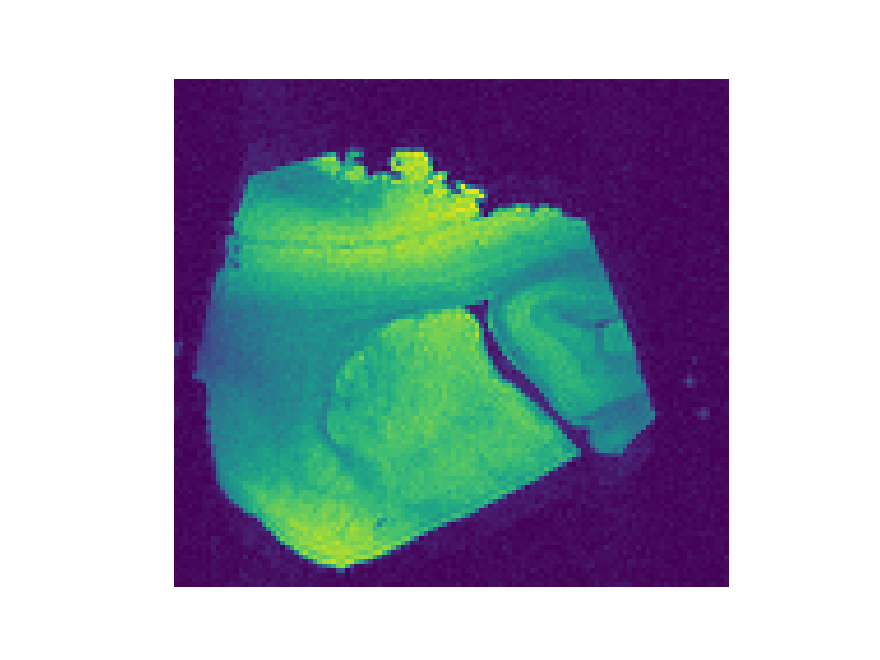

TypeError: imsave() missing 1 required positional argument: 'arr'

In [19]:
plt.figure()
plt.imshow(b0_slice[:,::-1])
plt.axis('off')
plt.imsave('/home/brysongray/dti_validate/outputs/b0_slice_55.png')

In [ ]:
dwi_b3k.shape

In [ ]:
plt.figure()
plt.imshow(dwi_b3k[55,:,:,10])

In [ ]:
import tifffile as tf

with tf.TiffFile('/home/brysongray/dti_validate/outputs/MD847-My147-2021.12.14-15.34.15_MD847_1_0439.tif') as tif:
    myelin_img = tif.asarray()


In [ ]:
myelin_img.shape

In [ ]:
plt.figure()
plt.imshow(myelin_img)